In [4]:
# imports
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [5]:
#  install tensorflow with conda
#  conda install -c conda-forge tensorflow

import tensorflow as tf

In [6]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [7]:
import keras as keras

In [8]:
print("Keras version:", keras.__version__)

Keras version: 3.5.0


In [9]:
# tensorflow imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [7]:
from google.colab import drive
drive.mount('/content/drive')

In [10]:
root_dir = Path.cwd()
#root_dir = Path('/content/drive/MyDrive/Lambton/ai_lab')

# Define the images directory
images_dir = root_dir / 'data' / 'images'

# Define the output directories
train_dir = root_dir / 'data' / 'training'
test_dir = root_dir / 'data' / 'test'

# Define the classes based on filename prefixes
classes = ['level0', 'level1', 'level2', 'level3']

prefix_mapping = {
    'level0': 'levle0_',
    'level1': 'levle1_',
    'level2': 'levle2_',
    'level3': 'levle3_'
}


In [11]:
# ensures that the training and test directories, along with their class subdirectories, exist.

for split_dir in [train_dir, test_dir]:
    for cls in classes:
        class_path = split_dir / cls
        class_path.mkdir(parents=True, exist_ok=True)

In [12]:
# Function to Split and Copy Images
def split_and_copy_images():
    for cls in classes:
        # Get the corresponding prefix for the current class
        cls_prefix = prefix_mapping.get(cls)

        if not cls_prefix:
            print(f"No prefix defined for class '{cls}'. Skipping.")
            continue

        # Retrieve all images belonging to the current class
        cls_images = [img for img in images_dir.iterdir() if img.is_file() and img.name.startswith(cls_prefix)]

        # Split the images into training and testing sets (75% train, 25% test)
        train_images, test_images = train_test_split(
            cls_images,
            test_size=0.25,
            random_state=42,  # Ensures reproducibility
            shuffle=True
        )

        # Copy training images
        for img_path in train_images:
            destination = train_dir / cls / img_path.name
            shutil.copy(img_path, destination)

        # Copy testing images
        for img_path in test_images:
            destination = test_dir / cls / img_path.name
            shutil.copy(img_path, destination)

        print(f"Class '{cls}': {len(train_images)} training and {len(test_images)} testing images copied.")

# Execute the function
split_and_copy_images()

print("All images have been successfully split into training and test sets.")

Class 'level0': 372 training and 125 testing images copied.
Class 'level1': 477 training and 160 testing images copied.
Class 'level2': 139 training and 47 testing images copied.
Class 'level3': 102 training and 35 testing images copied.
All images have been successfully split into training and test sets.


In [13]:
# Get the class names for our multi-class dataset
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(class_names)

['level0' 'level1' 'level2' 'level3']


In [14]:
# View an image
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = Path(target_dir) / target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)[0]

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder / random_image)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (3456, 3112, 3)


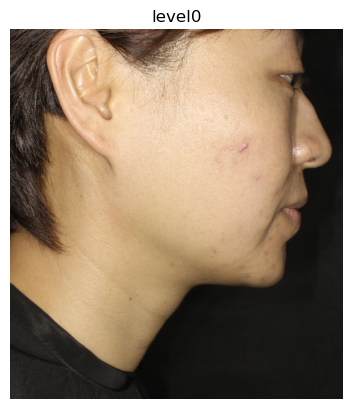

In [15]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(classes)) # get a random class name

## Transfer learning test

In [16]:
# Create datasets using image_dataset_from_directory
train_data = keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224, 224),
                                                                 batch_size=32,
                                                                 label_mode='categorical', # for multi-class classification
                                                                 shuffle=True)

test_data = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224, 224),
                                                                batch_size=32,
                                                                label_mode='categorical')

# Data augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
])

# Normalization layer
normalization_layer = keras.layers.Rescaling(1./255)

# Apply data augmentation and normalization to training data
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))

# Apply normalization to test data
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Prefetch data for better performance (overlap data preprocessing and model execution)
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)


Found 1090 files belonging to 4 classes.
Found 367 files belonging to 4 classes.


In [17]:
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Transfer learning: use pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model to prevent training
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the feature maps to a single vector
    Dropout(0.3),              # Add dropout to reduce overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),              # Another dropout layer
    Dense(4, activation='softmax')  # Output layer for 4 acne severity classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [18]:
# Train the model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=40,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.3465 - loss: 1.5078 - val_accuracy: 0.5014 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.4907 - loss: 1.0565 - val_accuracy: 0.4550 - val_loss: 0.9723 - learning_rate: 0.0010
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - accuracy: 0.5047 - loss: 1.0335 - val_accuracy: 0.5286 - val_loss: 0.9107 - learning_rate: 0.0010
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.5124 - loss: 0.9805 - val_accuracy: 0.5395 - val_loss: 0.8829 - learning_rate: 0.0010
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.5651 - loss: 0.9419 - val_accuracy: 0.6049 - val_loss: 0.8723 - learning_rate: 0.0010
Epoch 6/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.5683 - loss: 0.9333 - val_accuracy: 0.6158 - val_loss: 0.8487 - learning_rate: 0.0010
Epoch 7/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.5785 - loss: 0.9289 -

In [22]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.6127 - loss: 0.7726
Test accuracy: 0.62


## Normal training

In [63]:
# Create baseline model
model_baseline = Sequential([
    Input(shape=(224, 224, 3)),  # Define input shape using Input layer
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Increased dropout before output layer
    Dense(4, activation='softmax')  # 4 neurons for the 4 classes
])

# Compile the model with a learning rate scheduler
model_baseline.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])


model_baseline.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,420 (1.13 MB)

 Trainable params: 295,972 (1.13 MB)

 Non-trainable params: 448 (1.75 KB)

In [64]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=3,
                                 verbose=1,
                                 min_lr=1e-6)

# Optional: Set up a model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

In [65]:
# Fit the model with callbacks
history = model_baseline.fit(train_data,
                         epochs=10,
                         validation_data=test_data,
                         callbacks=[lr_scheduler, checkpoint])

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3862 - loss: 1.3795
Epoch 1: val_accuracy improved from -inf to 0.13351, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3862 - loss: 1.3777 - val_accuracy: 0.1335 - val_loss: 1.3855 - learning_rate: 0.0010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4297 - loss: 1.2272
Epoch 2: val_accuracy improved from 0.13351 to 0.43597, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4298 - loss: 1.2262 - val_accuracy: 0.4360 - val_loss: 1.3601 - learning_rate: 0.0010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4125 - loss: 1.1568
Epoch 3: val_accuracy did not improve from 0.43597
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4125 - loss: 1.1564 - val_accuracy: 0.1226 - val_loss: 1.4454 - learning_rate: 0.0010
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4061 - loss: 1.1858
Epoch 4: val_accuracy imp

In [66]:
# Evaluate on the test data
model_baseline.evaluate(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.4443 - loss: 1.2364


[1.2228482961654663, 0.46049046516418457]

## Plot results

### Normal training

In [67]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    # Extract loss and accuracy from the history
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))  # Get the number of epochs

    # Plot loss
    plt.figure(figsize=(12, 5))  # Set figure size for better readability
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the plots


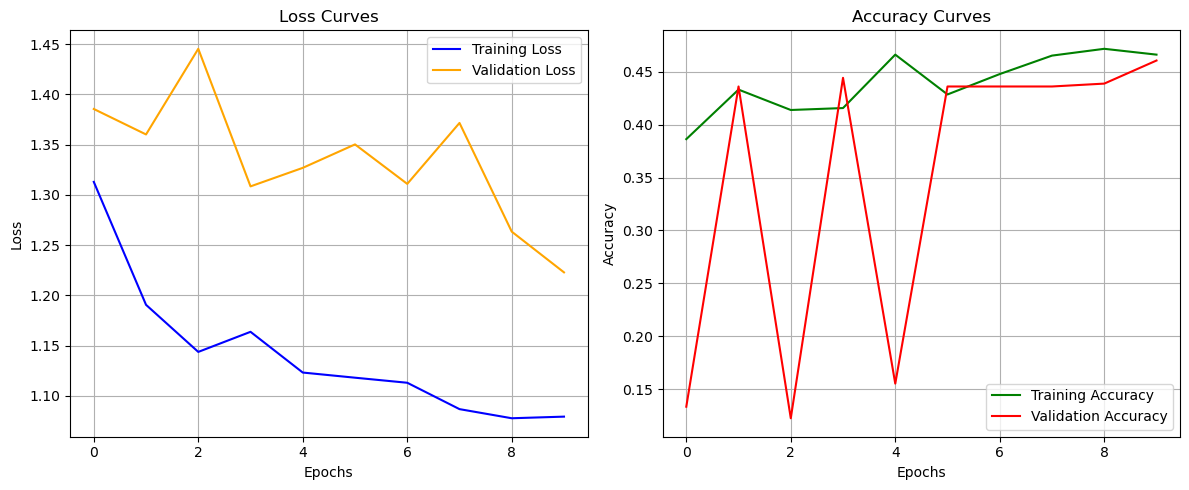

In [68]:
# Check out the model's loss curves on the 4 classes of data
plot_loss_curves(history)

### Transfer learning

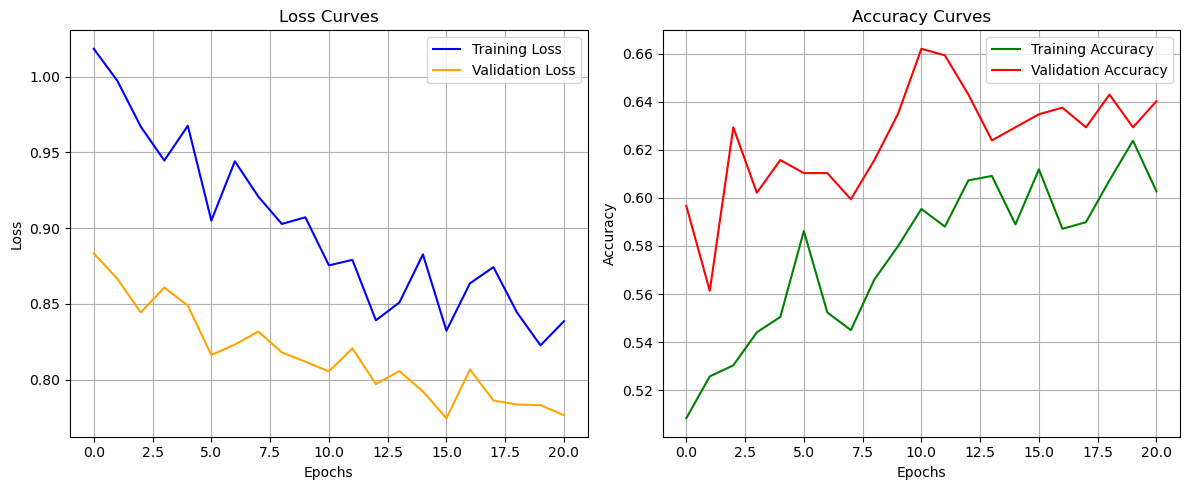

In [52]:
# Check out the model's loss curves on the 4 classes of data
plot_loss_curves(history)

## Save model

In [56]:
# Save the entire model
#model.save('/content/drive/MyDrive/Lambton/ai_lab/my_acne_model.keras')  # Save the model as a .h5 file
model.save('my_acne_model.keras')  # Save the model as a .h5 file

In [59]:
# Load the saved .keras model
from keras.models import load_model

#loaded_model = load_model('/content/drive/MyDrive/Lambton/ai_lab/my_acne_model.keras')
loaded_model = load_model('my_acne_model.keras')

In [60]:
# Evaluate the loaded model on test data
test_loss, test_acc = loaded_model.evaluate(test_data)
print(f"Loaded .keras model test accuracy: {test_acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.6142 - loss: 0.8180
Loaded .keras model test accuracy: 0.63


In [61]:
loaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,438 (10.50 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,970 (1.25 MB)

In [53]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [54]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


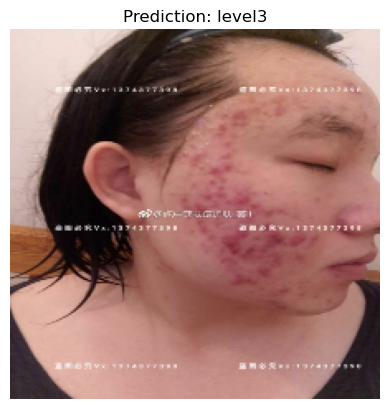

In [62]:
# Make a prediction 
test_image_path = test_dir / 'level3' / 'levle3_9.jpg'
pred_and_plot(model=loaded_model, 
              filename=str(test_image_path),
              class_names=class_names)